In [342]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [343]:
df = pd.read_excel('Online_Retail001.xlsx')
df.shape
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom


## 資料清理

In [344]:
df = df.loc[df['Quantity'] > 0]

df.shape

(9791, 8)

In [345]:
df = df.dropna(subset=['CustomerID'])

df.shape
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom


算總銷售量。

In [346]:
df['Sales'] = df['Quantity'] * df['UnitPrice']

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,45.00
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom,20.34
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom,16.50
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom,5.10
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom,87.60


## 每位顧客每份訂單的匯總

In [347]:
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Sales': 'sum',
    'InvoiceDate': 'max'
})

orders_df

Sales         InvoiceDate
CustomerID InvoiceNo                            
12347.0    549222      19.80 2011-04-07 10:43:00
           581180       8.40 2011-12-07 15:52:00
12348.0    568172      40.00 2011-09-25 13:13:00
12349.0    577609     339.00 2011-11-21 09:51:00
12352.0    544156      17.85 2011-02-16 12:33:00
...                      ...                 ...
18283.0    557956       3.80 2011-06-23 19:20:00
           565579       6.30 2011-09-05 12:35:00
           575668       1.25 2011-11-10 14:59:00
           578262      15.77 2011-11-23 13:27:00
           579673       1.65 2011-11-30 12:59:00

[5235 rows x 2 columns]

## 預測 3 個月 CLV

### 資料處理

以 3 個月為一個單位，計算每位顧客的購買量。

In [348]:
clv_freq = '3ME'

In [349]:
data_df = (
    orders_df.reset_index()
    .groupby([pd.Grouper(key='InvoiceDate', freq=clv_freq), 'CustomerID'])
    .agg({'Sales': ['sum', 'mean', 'count']})
)

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]

data_df = data_df.reset_index()

data_df.head(10)

,InvoiceDate,CustomerID,sales_sum,sales_mean,sales_count
0,2010-12-31,12370.0,2.95,2.95,1
1,2010-12-31,12377.0,15.00,15.00,1
2,2010-12-31,12386.0,27.00,27.00,1
3,2010-12-31,12427.0,15.30,15.30,1
4,2010-12-31,12429.0,45.00,45.00,1
5,2010-12-31,12433.0,15.12,15.12,1
6,2010-12-31,12481.0,17.70,17.70,1
7,2010-12-31,12515.0,25.50,25.50,1
8,2010-12-31,12540.0,10.08,10.08,1
9,2010-12-31,12567.0,21.96,21.96,1


### 製作 DIC，各日期的分類標籤

In [350]:
unique_dates = sorted(data_df['InvoiceDate'].dt.date.unique(), reverse=True)

date_to_label = {date: f'M_{i+1}' for i, date in enumerate(unique_dates)}

data_df['M'] = data_df['InvoiceDate'].dt.date.map(date_to_label)

data_df

,InvoiceDate,CustomerID,sales_sum,sales_mean,sales_count,M
0,2010-12-31,12370.0,2.95,2.950000,1,M_5
1,2010-12-31,12377.0,15.00,15.000000,1,M_5
2,2010-12-31,12386.0,27.00,27.000000,1,M_5
3,2010-12-31,12427.0,15.30,15.300000,1,M_5
4,2010-12-31,12429.0,45.00,45.000000,1,M_5
...,...,...,...,...,...,...
3865,2011-12-31,18229.0,19.90,19.900000,1,M_1
3866,2011-12-31,18252.0,8.35,8.350000,1,M_1
3867,2011-12-31,18263.0,20.40,20.400000,1,M_1
3868,2011-12-31,18272.0,56.32,56.320000,1,M_1


### Building Sample Set

挑選特徵值。

In [351]:
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'],
    values=['sales_sum', 'sales_mean', 'sales_count'],
    columns='M',
    index='CustomerID',
)

features_df.columns = ['_'.join(col) for col in features_df.columns]

features_df


,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_mean_M_2,sales_mean_M_3,sales_mean_M_4,sales_mean_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12347.0,NaN,1.0,NaN,NaN,NaN,19.80,NaN,NaN,NaN,19.80,NaN,NaN
12348.0,1.0,NaN,NaN,NaN,40.00,NaN,NaN,NaN,40.00,NaN,NaN,NaN
12352.0,1.0,NaN,1.0,NaN,18.75,NaN,17.85,NaN,18.75,NaN,17.85,NaN
12354.0,NaN,1.0,NaN,NaN,NaN,23.40,NaN,NaN,NaN,23.40,NaN,NaN
12356.0,NaN,NaN,1.0,NaN,NaN,NaN,20.16,NaN,NaN,NaN,20.16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18261.0,1.0,NaN,NaN,NaN,17.00,NaN,NaN,NaN,17.00,NaN,NaN,NaN
18263.0,NaN,1.0,NaN,NaN,NaN,19.92,NaN,NaN,NaN,19.92,NaN,NaN
18265.0,1.0,NaN,NaN,NaN,15.90,NaN,NaN,NaN,15.90,NaN,NaN,NaN


考慮到有可能某些月沒有購買資料，所以這裡補0。

In [352]:
features_df = features_df.fillna(0)

features_df

,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_mean_M_2,sales_mean_M_3,sales_mean_M_4,sales_mean_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12347.0,0.0,1.0,0.0,0.0,0.00,19.80,0.00,0.0,0.00,19.80,0.00,0.0
12348.0,1.0,0.0,0.0,0.0,40.00,0.00,0.00,0.0,40.00,0.00,0.00,0.0
12352.0,1.0,0.0,1.0,0.0,18.75,0.00,17.85,0.0,18.75,0.00,17.85,0.0
12354.0,0.0,1.0,0.0,0.0,0.00,23.40,0.00,0.0,0.00,23.40,0.00,0.0
12356.0,0.0,0.0,1.0,0.0,0.00,0.00,20.16,0.0,0.00,0.00,20.16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18261.0,1.0,0.0,0.0,0.0,17.00,0.00,0.00,0.0,17.00,0.00,0.00,0.0
18263.0,0.0,1.0,0.0,0.0,0.00,19.92,0.00,0.0,0.00,19.92,0.00,0.0
18265.0,1.0,0.0,0.0,0.0,15.90,0.00,0.00,0.0,15.90,0.00,0.00,0.0


挑選目標值。

In [353]:
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]

response_df

,CustomerID,sales_sum
2735,12347.0,8.40
2736,12349.0,339.00
2737,12357.0,48.96
2738,12358.0,142.80
2739,12359.0,34.80
...,...,...
3865,18229.0,19.90
3866,18252.0,8.35
3867,18263.0,20.40
3868,18272.0,56.32


In [354]:
response_df.columns = ['CustomerID', 'CLV_'+clv_freq]

response_df

,CustomerID,CLV_3ME
2735,12347.0,8.40
2736,12349.0,339.00
2737,12357.0,48.96
2738,12358.0,142.80
2739,12359.0,34.80
...,...,...
3865,18229.0,19.90
3866,18252.0,8.35
3867,18263.0,20.40
3868,18272.0,56.32


合併特徵、目標值。

In [355]:
sample_set_df = features_df.merge(
    response_df,
    left_index=True,
    right_on='CustomerID',
    how='left'
)

sample_set_df


,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_mean_M_2,sales_mean_M_3,sales_mean_M_4,sales_mean_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3ME
2735.0,0.0,1.0,0.0,0.0,0.00,19.80,0.00,0.0,0.00,19.80,0.00,0.0,12347.0,8.40
NaN,1.0,0.0,0.0,0.0,40.00,0.00,0.00,0.0,40.00,0.00,0.00,0.0,12348.0,NaN
NaN,1.0,0.0,1.0,0.0,18.75,0.00,17.85,0.0,18.75,0.00,17.85,0.0,12352.0,NaN
NaN,0.0,1.0,0.0,0.0,0.00,23.40,0.00,0.0,0.00,23.40,0.00,0.0,12354.0,NaN
NaN,0.0,0.0,1.0,0.0,0.00,0.00,20.16,0.0,0.00,0.00,20.16,0.0,12356.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,1.0,0.0,0.0,0.0,17.00,0.00,0.00,0.0,17.00,0.00,0.00,0.0,18261.0,NaN
3867.0,0.0,1.0,0.0,0.0,0.00,19.92,0.00,0.0,0.00,19.92,0.00,0.0,18263.0,20.40
NaN,1.0,0.0,0.0,0.0,15.90,0.00,0.00,0.0,15.90,0.00,0.00,0.0,18265.0,NaN
3868.0,1.0,0.0,0.0,0.0,30.00,0.00,0.00,0.0,30.00,0.00,0.00,0.0,18272.0,56.32


因為 X, Y 筆數不同，所以合併後 Y 有可能會是空值，故補 0。

In [356]:
sample_set_df = sample_set_df.fillna(0)

sample_set_df

,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_mean_M_2,sales_mean_M_3,sales_mean_M_4,sales_mean_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3ME
2735.0,0.0,1.0,0.0,0.0,0.00,19.80,0.00,0.0,0.00,19.80,0.00,0.0,12347.0,8.40
NaN,1.0,0.0,0.0,0.0,40.00,0.00,0.00,0.0,40.00,0.00,0.00,0.0,12348.0,0.00
NaN,1.0,0.0,1.0,0.0,18.75,0.00,17.85,0.0,18.75,0.00,17.85,0.0,12352.0,0.00
NaN,0.0,1.0,0.0,0.0,0.00,23.40,0.00,0.0,0.00,23.40,0.00,0.0,12354.0,0.00
NaN,0.0,0.0,1.0,0.0,0.00,0.00,20.16,0.0,0.00,0.00,20.16,0.0,12356.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,1.0,0.0,0.0,0.0,17.00,0.00,0.00,0.0,17.00,0.00,0.00,0.0,18261.0,0.00
3867.0,0.0,1.0,0.0,0.0,0.00,19.92,0.00,0.0,0.00,19.92,0.00,0.0,18263.0,20.40
NaN,1.0,0.0,0.0,0.0,15.90,0.00,0.00,0.0,15.90,0.00,0.00,0.0,18265.0,0.00
3868.0,1.0,0.0,0.0,0.0,30.00,0.00,0.00,0.0,30.00,0.00,0.00,0.0,18272.0,56.32


### 執行回歸模型

In [357]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [358]:
y_columns = 'CLV_'+clv_freq

x_columns = [x for x in sample_set_df.columns if x not in ['CustomerID', y_columns]]

x_columns, y_columns

(['sales_count_M_2',
  'sales_count_M_3',
  'sales_count_M_4',
  'sales_count_M_5',
  'sales_mean_M_2',
  'sales_mean_M_3',
  'sales_mean_M_4',
  'sales_mean_M_5',
  'sales_sum_M_2',
  'sales_sum_M_3',
  'sales_sum_M_4',
  'sales_sum_M_5'],
 'CLV_3ME')

嘗試回歸模型。

In [359]:
X_train, X_test, y_train, y_test = train_test_split(
    sample_set_df[x_columns],
    sample_set_df[y_columns],
    test_size=0.3,
    random_state=1
)

In [360]:
reg_fit = LinearRegression()

reg_fit.fit(X_train, y_train)

LinearRegression()

查看模型係數和截距。

In [361]:
print(f"Intercept: {reg_fit.intercept_:0.2f}")

Intercept: 6.77


In [362]:
coef = pd.DataFrame({
    'features': x_columns,
    'coef': reg_fit.coef_
})

coef

,features,coef
0,sales_count_M_2,7.252405
1,sales_count_M_3,-7.218524
2,sales_count_M_4,1.084923
3,sales_count_M_5,-2.218219
4,sales_mean_M_2,0.177642
5,sales_mean_M_3,-1.340468
6,sales_mean_M_4,-0.631384
7,sales_mean_M_5,0.613424
8,sales_sum_M_2,-0.159980
9,sales_sum_M_3,1.368464


### 執行評估

In [363]:
from sklearn.metrics import r2_score, median_absolute_error

In [364]:
X_train_preds = reg_fit.predict(X_train)
X_test_preds = reg_fit.predict(X_test)

$R^2$:

In [365]:
print('In-Sample R-Squared: %0.4f' % r2_score(y_train, X_train_preds))
print('Out-of-Sample R-Squared: %0.4f' % r2_score(y_test, X_test_preds))

In-Sample R-Squared: 0.6818
Out-of-Sample R-Squared: 0.3296


MAE:

In [366]:
print('In-Sample MAE: %0.4f' % median_absolute_error(y_train, X_train_preds))
print('Out-of-Sample MAE: %0.4f' % median_absolute_error(y_test, X_test_preds))

In-Sample MAE: 9.6658
Out-of-Sample MAE: 10.7554


散布圖：

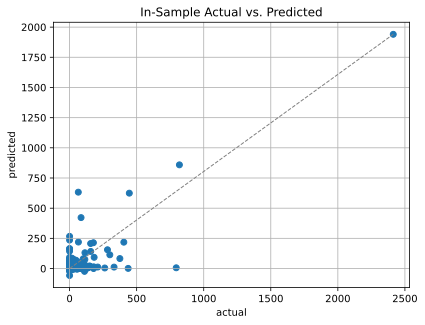

In [367]:
plt.scatter(y_train, X_train_preds)
plt.plot([0, max(y_train)], [0, max(X_train_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('In-Sample Actual vs. Predicted')
plt.grid()

plt.show()

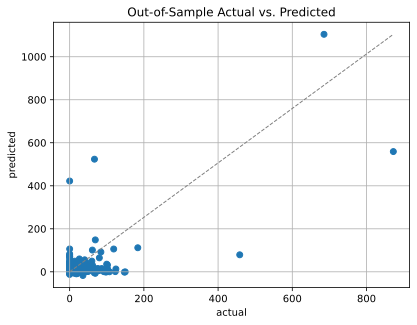

In [368]:
plt.scatter(y_test, X_test_preds)
plt.plot([0, max(y_test)], [0, max(X_test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Out-of-Sample Actual vs. Predicted')
plt.grid()

plt.show()